# Libraries

In [173]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as io
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller

sns.set_theme()
io.templates.default = 'presentation'

# Custom Plot
def create_corr_plot(series, alpha = 0.05, plot_pacf = False):
  corr_array = pacf(series.dropna(), alpha = alpha) if plot_pacf else acf(series.dropna(), alpha = alpha)
  lower_y = corr_array[1][:,0] - corr_array[0]
  upper_y = corr_array[1][:,1] - corr_array[0]
  length = len(corr_array[0])

  fig = go.Figure()

  for x in range(length):
    fig.add_scatter(x = (x, x), 
                    y = (0, corr_array[0][x]), 
                    mode = 'lines', 
                    line_color = '#3f3f3f')

  fig.add_scatter(x = np.arange(length), 
                  y = corr_array[0], 
                  mode = 'markers', 
                  marker_color = '#1f77b4',
                  marker_size = 12)
  
  fig.add_scatter(x=np.arange(len(corr_array[0])), 
                  y=upper_y, 
                  mode='lines', 
                  line_color='rgba(255,255,255,0)')
  
  fig.add_scatter(x = np.arange(length), 
                  y = lower_y, 
                  mode = 'lines', 
                  fillcolor = 'rgba(32, 146, 230,0.3)',
                  fill='tonexty', 
                  line_color='rgba(255,255,255,0)')
  
  fig.update_traces(showlegend = False)
  fig.update_xaxes(range = [-1, length])
  fig.update_yaxes(zerolinecolor = '#000000')
  
  title = 'Partial Autocorrelation (PACF)' if plot_pacf else f"Autocorrelation (ACF)"
  fig.update_layout(title = title, 
                    title_x = 0.5, 
                    width = 1200, 
                    height = 600)
  fig.show()
  return fig

# Mission Zero - Determining Energy Consumption per month for all of France

<img src="https://github.com/amaye15/Open_Classroom/blob/main/data_analysis_projects/project_nine/mission_zero_workflow.png?raw=true">

I have added this mission just to explain what was done to the data before completing the real missions.

- Heat Data 
  - Description: 
    - This data was obtained from the french government.
    - The data represents the amount of energy consumption required for heating in order the maintain the reference temperature for a given station.
  - Reference: https://cegibat.grdf.fr/simulateur/calcul-dju 
  - Variables:
    - Year, indicates year.
    - Months, mutiple columns comprising of energy data related to each day of the month.
    - Total, indicates total energy demands required for heating a given month.
    - Station, the location of the weather station (prefecture & city).
    - Start, start date of data collection.
    - End, end date of data collection.
    - Temperature Reference, the temperature used to determine heating needs.
- Energy Data
  - Description:
    - This data was obtained from the french government and then modified to monthly records.
    - The data represents energy consumption for all of France and the sources of energy (coal, gas, nuclear, etc.).
  - Reference: https://www.rte-france.com/eco2mix/telecharger-les-indicateurs 
  - Variables:
    - Consommation, total energy consumption for France.
    - Prevision_j1, predicted energy consumption. 
    - Prevision_j, predicted energy consumption.
    - Fioul, energy consumption derived from oil.
    - Charbon, energy consumption derived from coal.
    - Gaz, energy consumption derived from gas. 
    - Nucleaire, energy consumption derived from nuclear.
    - Eolien, energy consumption derived from wind.
    - Solaire, energy consumption derived from solar.
    - Hydraulique, energy consumption derived from hydraulics.
    - Pompage, energy consumption derived from pumping. 
    - Bioenergies, energy consumption derived from bioenergies.

## Heat Data - Import

In [174]:
# Get Data
heat_data = pd.read_csv("https://raw.githubusercontent.com/amaye15/Open_Classroom/main/data_analysis_projects/project_nine/data/heating_data.csv", 
                   index_col = 0)
# Check
heat_data

,Year,January,February,March,April,May,June,July,August,September,October,November,December,Total,Station,Start,End,Temperature Reference
0,2022,519,328,282,233,81,21,0,0,0,0,0,0,1 463,01 - AMBERIEU,01/01/2009,15/06/2022,18
1,2021,493,295,332,265,176,33,37,54,60,219,401,445,2 809,01 - AMBERIEU,01/01/2009,15/06/2022,18
2,2020,422,305,314,155,122,68,32,27,80,205,294,410,2 434,01 - AMBERIEU,01/01/2009,15/06/2022,18
3,2019,490,335,287,223,180,51,23,38,84,139,334,372,2 556,01 - AMBERIEU,01/01/2009,15/06/2022,18
4,2018,324,449,324,138,92,35,16,22,63,184,302,389,2 337,01 - AMBERIEU,01/01/2009,15/06/2022,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2013,455,436,413,242,186,76,18,33,71,124,328,364,2 745,95 - ROISSY,01/01/2009,15/06/2022,18
1396,2012,362,469,247,255,118,63,39,21,92,174,313,363,2 515,95 - ROISSY,01/01/2009,15/06/2022,18
1397,2011,414,325,277,129,95,57,56,34,45,146,248,332,2 156,95 - ROISSY,01/01/2009,15/06/2022,18
1398,2010,532,391,322,208,177,55,14,40,90,200,329,551,2 909,95 - ROISSY,01/01/2009,15/06/2022,18


## Heat Data - Check

In [175]:
# Clean "Total" Column
heat_data["Total"] = heat_data["Total"].replace(regex = r" ", value = "").astype(float)
# Months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
# IDs
ids = ['Year','Station', 'Start', 'End','Temperature Reference', 'Total']
# Restructure Data
heat_data_v2 = heat_data.melt(value_vars = months,
                              id_vars = ids,
                              var_name = "Month",
                              value_name = "Energy")
# Visualise
fig = px.box(heat_data_v2, x = "Month", y = "Energy")
fig = fig.update_layout(width = 1200, 
                        height = 600, 
                        title_text = "Heat Data - Before Replacing Outliers", 
                        title_x = 0.5)
fig.show()

## Heat Data - Replace Outliers 

In [176]:
# Heat Data Copy 
heat_data_v2 = heat_data.copy()
# First Quantile - q1
q1 = heat_data_v2[months].quantile(0.25)
# Third Quantile - q3
q3 = heat_data_v2[months].quantile(0.75)
# Interquantile Range - IQR
iqr = q3 - q1
# Lower Fence
lf = q1 - (1.5 * iqr)
# Upper Fence
uf = q3 + (1.5 * iqr)
# Lower Fence Loop
for name, value in lf.to_dict().items():
  heat_data_v2.loc[heat_data_v2[name] < value, name] = value
# Upper Fence Loop
for name, value in uf.to_dict().items():
  heat_data_v2.loc[heat_data_v2[name] > value, name] = value
# Restructure Data
heat_data_v2 = heat_data_v2.melt(value_vars = months,
                                 id_vars = ids,
                                 var_name = "Month",
                                 value_name = "Energy")
# Orginal Values
heat_data_v2["Original Energy"] = heat_data.melt(value_vars = months, id_vars = ids, var_name = "Month", value_name = "Energy")["Energy"].values
# DataFrame - Visualisation
df_vis = heat_data_v2[["Month", "Energy", "Original Energy"]].melt(id_vars = "Month")
# Visualise
fig = px.box(df_vis, x = "Month", y = "value", color = "variable")
fig = fig.update_layout(width = 1200, 
                        height = 600, 
                        title_text = "Données de chauffage", 
                        title_x = 0.5)
fig.show()
# Check
heat_data_v2.head(10)

,Year,Station,Start,End,Temperature Reference,Total,Month,Energy,Original Energy
0,2022,01 - AMBERIEU,01/01/2009,15/06/2022,18,1463.0,January,519.0,519
1,2021,01 - AMBERIEU,01/01/2009,15/06/2022,18,2809.0,January,493.0,493
2,2020,01 - AMBERIEU,01/01/2009,15/06/2022,18,2434.0,January,422.0,422
3,2019,01 - AMBERIEU,01/01/2009,15/06/2022,18,2556.0,January,490.0,490
4,2018,01 - AMBERIEU,01/01/2009,15/06/2022,18,2337.0,January,324.0,324
5,2017,01 - AMBERIEU,01/01/2009,15/06/2022,18,2592.0,January,584.0,584
6,2016,01 - AMBERIEU,01/01/2009,15/06/2022,18,2594.0,January,363.0,363
7,2015,01 - AMBERIEU,01/01/2009,15/06/2022,18,2454.0,January,443.0,443
8,2014,01 - AMBERIEU,01/01/2009,15/06/2022,18,2230.0,January,361.0,361
9,2013,01 - AMBERIEU,01/01/2009,15/06/2022,18,2859.0,January,486.0,486


## Heat Data - Median per Month

In [177]:
# Restructure & Calculate Median
heat_data_v3 = heat_data_v2.groupby(by = ["Year", "Month"], as_index = False).median().drop(labels = "Original Energy", axis = 1)
# Check
heat_data_v3

,Year,Month,Temperature Reference,Total,Energy
0,2009,April,18.0,2517.5,185.500
1,2009,August,18.0,2517.5,25.500
2,2009,December,18.0,2517.5,413.000
3,2009,February,18.0,2517.5,374.000
4,2009,January,18.0,2517.5,494.000
...,...,...,...,...,...
163,2022,March,18.0,1319.5,267.000
164,2022,May,18.0,1319.5,85.500
165,2022,November,18.0,1319.5,53.875
166,2022,October,18.0,1319.5,0.000


## Energy Data - Import

In [178]:
# Get Data
energy_data = pd.read_csv("https://raw.githubusercontent.com/amaye15/Open_Classroom/main/data_analysis_projects/project_nine/data/electricity_data.csv")
# Check
energy_data

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies
0,2012-01-01,2471592.0,4901850.0,4841050.0,23649.0,758.0,181778.0,2153346.0,188459.0,6255.0,367472.0,-86821.0,33411.0
1,2012-01-02,2912815.0,5796450.0,5739050.0,23598.0,378.0,194404.0,2557111.0,147353.0,4267.0,412364.0,-50571.0,31219.0
2,2012-01-03,3252581.0,6349550.0,6392550.0,24700.0,205.0,193376.0,2794380.0,228569.0,6768.0,484559.0,-48850.0,31888.0
3,2012-01-04,3265403.0,6455450.0,6430900.0,26208.0,7.0,178234.0,2767347.0,203392.0,8655.0,490193.0,-42190.0,32737.0
4,2012-01-05,3319555.0,6410150.0,6484500.0,25809.0,16.0,203859.0,2712466.0,249564.0,3207.0,516675.0,-40085.0,32991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,2020-12-27,2990748.0,5842450.0,5976350.0,4460.0,404.0,116636.0,2125269.0,519656.0,12306.0,298783.0,-82738.0,53499.0
3284,2020-12-28,3101704.0,6460350.0,6156450.0,4495.0,421.0,186115.0,2268938.0,368355.0,19619.0,433347.0,-39110.0,52210.0
3285,2020-12-29,3138620.0,6264900.0,6239650.0,4494.0,426.0,236159.0,2370694.0,207355.0,23846.0,387266.0,-21963.0,52231.0
3286,2020-12-30,3176874.0,6332550.0,6338750.0,4490.0,387.0,231034.0,2383663.0,165890.0,27771.0,339525.0,-33099.0,52108.0


## Energy Data - Check

In [179]:
# Clean "date" Column
energy_data["date"] = pd.to_datetime(energy_data["date"])
# Create "Year" Column
energy_data["Year"] = energy_data["date"].dt.year
# Create "Month" Column
energy_data["Month_Transformed"] = energy_data["date"].dt.month
# Create "Month" Column
energy_data["Month"] = energy_data["date"].dt.month_name()
# Check
fig = px.box(energy_data, x = "Month", y = "consommation")
fig = fig.update_layout(width = 1200, 
                        height = 600, 
                        title_text = "Energy Data - Before Replacing Outliers", 
                        title_x = 0.5)
fig.show()

energy_data.head(10)

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,Year,Month_Transformed,Month
0,2012-01-01,2471592.0,4901850.0,4841050.0,23649.0,758.0,181778.0,2153346.0,188459.0,6255.0,367472.0,-86821.0,33411.0,2012,1,January
1,2012-01-02,2912815.0,5796450.0,5739050.0,23598.0,378.0,194404.0,2557111.0,147353.0,4267.0,412364.0,-50571.0,31219.0,2012,1,January
2,2012-01-03,3252581.0,6349550.0,6392550.0,24700.0,205.0,193376.0,2794380.0,228569.0,6768.0,484559.0,-48850.0,31888.0,2012,1,January
3,2012-01-04,3265403.0,6455450.0,6430900.0,26208.0,7.0,178234.0,2767347.0,203392.0,8655.0,490193.0,-42190.0,32737.0,2012,1,January
4,2012-01-05,3319555.0,6410150.0,6484500.0,25809.0,16.0,203859.0,2712466.0,249564.0,3207.0,516675.0,-40085.0,32991.0,2012,1,January
5,2012-01-06,3314845.0,6523550.0,6541700.0,25834.0,33400.0,198577.0,2731599.0,128516.0,9441.0,524023.0,-39868.0,33890.0,2012,1,January
6,2012-01-07,3031707.0,6096550.0,5989200.0,23589.0,3124.0,187348.0,2664738.0,151550.0,5574.0,393214.0,-76750.0,34793.0,2012,1,January
7,2012-01-08,2833583.0,5696950.0,5645450.0,23611.0,762.0,186022.0,2620989.0,78467.0,5519.0,376425.0,-83590.0,34492.0,2012,1,January
8,2012-01-09,3227375.0,6532500.0,6385200.0,23753.0,20048.0,313799.0,2779083.0,59605.0,7716.0,455047.0,-38687.0,33600.0,2012,1,January
9,2012-01-10,3290786.0,6608850.0,6558650.0,23679.0,34414.0,321939.0,2796039.0,27035.0,9624.0,447771.0,-35968.0,32709.0,2012,1,January


## Energy Data - Replace Outliers 

In [180]:
# Copy Energy Data
energy_data_v2 = energy_data.copy()
# Column Names
col_names = ["Month_Transformed",'consommation', 'prevision_j1', 'prevision_j', 'fioul', 'charbon', 'gaz', 'nucleaire', 'eolien', 'solaire', 'hydraulique', 'pompage', 'bioenergies']
# First Quantile - q1
q1 = energy_data_v2[col_names].quantile(0.25)
# Third Quantile - q3
q3 = energy_data_v2[col_names].quantile(0.75)
# Interquantile Range - IQR
iqr = q3 - q1
# Lower Fence
lf = q1 - (1.5 * iqr)
# Upper Fence
uf = q3 + (1.5 * iqr)
# Lower Fence Loop
for name, value in lf.to_dict().items():
  energy_data_v2.loc[energy_data_v2[name] < value, name] = value
# Upper Fence Loop
for name, value in uf.to_dict().items():
  energy_data_v2.loc[energy_data_v2[name] > value, name] = value
# Restructure Data
energy_data_v3 = energy_data_v2.groupby(by = ["Year", "Month"], as_index = False).median()
# Visualise
fig = px.box(energy_data, x = "Month", y = "consommation")
fig = fig.update_layout(width = 1200, 
                        height = 600, 
                        title_text = "Enegry Data - After Replacing Outliers", 
                        title_x = 0.5)
fig.show()

energy_data_v2.head(10)

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,Year,Month_Transformed,Month
0,2012-01-01,2471592.0,4901850.0,4841050.0,23649.0,758.0,181778.0,2153346.0,188459.0,6255.0,367472.0,-79298.75,33411.0,2012,1,January
1,2012-01-02,2912815.0,5796450.0,5739050.0,23598.0,378.0,194404.0,2557111.0,147353.0,4267.0,412364.0,-50571.00,31219.0,2012,1,January
2,2012-01-03,3252581.0,6349550.0,6392550.0,24700.0,205.0,193376.0,2794380.0,228569.0,6768.0,484559.0,-48850.00,31888.0,2012,1,January
3,2012-01-04,3265403.0,6455450.0,6430900.0,26208.0,7.0,178234.0,2767347.0,203392.0,8655.0,490193.0,-42190.00,32737.0,2012,1,January
4,2012-01-05,3319555.0,6410150.0,6484500.0,25809.0,16.0,203859.0,2712466.0,249564.0,3207.0,516675.0,-40085.00,32991.0,2012,1,January
5,2012-01-06,3314845.0,6523550.0,6541700.0,25834.0,33400.0,198577.0,2731599.0,128516.0,9441.0,524023.0,-39868.00,33890.0,2012,1,January
6,2012-01-07,3031707.0,6096550.0,5989200.0,23589.0,3124.0,187348.0,2664738.0,151550.0,5574.0,393214.0,-76750.00,34793.0,2012,1,January
7,2012-01-08,2833583.0,5696950.0,5645450.0,23611.0,762.0,186022.0,2620989.0,78467.0,5519.0,376425.0,-79298.75,34492.0,2012,1,January
8,2012-01-09,3227375.0,6532500.0,6385200.0,23753.0,20048.0,313799.0,2779083.0,59605.0,7716.0,455047.0,-38687.00,33600.0,2012,1,January
9,2012-01-10,3290786.0,6608850.0,6558650.0,23679.0,34414.0,321939.0,2796039.0,27035.0,9624.0,447771.0,-35968.00,32709.0,2012,1,January


# Mission One - Remove Temperature Effect from Monthly Energy Consumption

<img src="https://github.com/amaye15/Open_Classroom/blob/main/data_analysis_projects/project_nine/mission_one_workflow.png?raw=true">

One method that can be used to remove temperature effects is linear regression.

Linear regression can be defined generally as:


$Y = B_0 + B_1X_1 + ... B_iX_i + \varepsilon$

Where:
- $Y$, target variable
- $B_0$, intercept
- $B_i$, weight or coefficient
- $X_i$, explanatory variable
- $\varepsilon_t$, residuals

In order to remove temperature effects onbe can reaarage the following equation:

- $Y_{Corrected} = Y - (B_{Temperature}X_{Temperature})$ 
- $Y_{Corrected} = B_0 + \varepsilon$

## Combine Datasets - Single Linear Regression - Strength of Relation

In [181]:
# Wide Format 
combo_data = energy_data_v3.merge(heat_data_v3, on = ["Year", "Month"]).sort_values(["Year", "Month_Transformed"]).reset_index(drop = True)
# Long Format
combo_data_v2 = combo_data.melt(id_vars = ["Year", "Month", "Month_Transformed", "Temperature Reference", "consommation", "Total"])
# Linear Regression for each variable
fig = px.scatter(combo_data_v2, 
                 x = "value" , 
                 y = "consommation", 
                 trendline="ols", 
                 facet_col='variable', 
                 trendline_color_override = 'red', 
                 facet_col_wrap = 3)
# Collect Results
results = px.get_trendline_results(fig)
# Edit Figure
fig = fig.update_layout(width = 1200, 
                        height = 800)
fig = fig.update_xaxes(matches = None)
# Complicated
  # Returns variable name & R2 value
fig = fig.for_each_annotation(lambda a: a.update(text = a.text.split("=")[-1] + " = " + str(round(results.query(f"variable == '{a.text.split('=')[-1]}'").px_fit_results.iloc[0].rsquared, 4))))
fig = fig.update_layout(title_text = f"Consommation vs Variable", 
                        title_x = 0.5)
# Show Figure
fig

## Combine Datasets - Multiple Linear Regression - Importance of Relation

In [182]:
# Features
x = combo_data[['Energy', 'prevision_j1', 'prevision_j', 'fioul', 'charbon', 'gaz', 'nucleaire', 'eolien', 'solaire', 'hydraulique', 'pompage', 'bioenergies']]
# Target
y = combo_data[["consommation"]]
# Multiple Linear Regression
model = LinearRegression()
# Fit
model.fit(x, y)
# Classifiy Direction
colors = ['Positive' if c > 0 else 'Negative' for c in model.coef_.flatten()]
# Create Figure
fig = px.bar(x = x.columns, 
             y = model.coef_.flatten(), 
             color = colors,
             labels = dict(x = 'Feature', y = 'Weight'))
# Edit figure
fig = fig.update_layout(width = 1200,
                        height = 600, 
                        title_text = 'Feature Importance', 
                        title_x = 0.5)
# Show
fig.show()

## Combine Datasets - Single Linear Regression - Energy

In [183]:
fig = px.scatter(combo_data, 
                 x = "Energy" , 
                 y = "consommation", 
                 trendline="ols", 
                 trendline_color_override = 'red')
fig.update_layout(width = 1200, 
                  height = 600, 
                  title_text=f"Consommation = Intercept + Weight x Energy + Residuals", 
                  title_x=0.5)
fig.show()

results.query(f"variable == 'Energy'").iloc[0]["px_fit_results"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     1101.
Date:                Mon, 30 Jan 2023   Prob (F-statistic):           8.46e-58
Time:                        13:16:14   Log-Likelihood:                -1430.1
No. Observations:                 108   AIC:                             2864.
Df Residuals:                     106   BIC:                             2869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.986e+06   2.34e+04     84.914      0.000    1.94e+06    2.03e+06
x1          3238.2960     97.615     33.174      0.000    3044.765    3431.827
==============================================================================
Omnibus:                        1.596   Durbin-Watson:                   1.079
Prob(Omnibus):                  0.450   Jarque-Bera (JB):                1.322
Skew:                          -0.270   Prob(JB):                        0.516
Kurtosis:                       3.040   Cond. No.                         423.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###  Combine Datasets - Linear Regression - Normality Test
- Jarque-Bera Test
  - $H_o$, data is normally distributed
- Shapiro-Wilk Test
  - $H_o$, data is normally distributed
- Kolmogorov-Smirnov Test
  - $H_o$, data comes from the specified distribution

In [184]:
from scipy import stats

regression = smf.ols('consommation~Energy', data= combo_data).fit()

print('p value of Jarque-Bera test is: ', stats.jarque_bera(regression.resid)[1])
print('p value of Shapiro-Wilk test is: ', stats.shapiro(regression.resid)[1])
print('p value of Kolmogorov-Smirnov test is: ', stats.kstest(regression.resid, 'norm')[1])

p value of Jarque-Bera test is:  0.5163542762112643
p value of Shapiro-Wilk test is:  0.45482489466667175
p value of Kolmogorov-Smirnov test is:  1.413490926308079e-28


###  Combine Datasets - Linear Regression - Homogeneity Test
- Goldfeld–Quandt Test
  - $H_o$, variances of the errors are not constant
- Breusch–Pagan Test
  - $H_o$, the residuals are distributed with equal variance
- White Test
  - $H_o$,  the residuals are distributed with equal variance

In [185]:
import statsmodels.stats.api as sms

print('p value of Goldfeld–Quandt test is: ', sms.het_goldfeldquandt(regression.resid, regression.model.exog)[1])
print('p value of Breusch–Pagan test is: ', sms.het_breuschpagan(regression.resid, regression.model.exog)[1])
print('p value of White test is: ', sms.het_white(regression.resid, regression.model.exog)[1])

p value of Goldfeld–Quandt test is:  0.17797681538171695
p value of Breusch–Pagan test is:  0.38316907008924617
p value of White test is:  0.6826248550628531


###  Combine Datasets - Linear Regression - Stationarity Test
- Durbin-Watson Test
  - 2 is no autocorrelation
  - 0 to < 2 is positive autocorrelation (common in time series data)
  - < 2 to 4 is negative autocorrelation (less common in time series data)
- Breusch-Godfrey Test
  - $H_o$,  error variances are all equal

In [186]:
import statsmodels.stats.api as sms
print('The Durbin-Watson statistic is: ', sms.durbin_watson(regression.resid))
print('p value of Breusch-Godfrey test is: ', sms.acorr_breusch_godfrey(regression, nlags=1)[3])

The Durbin-Watson statistic is:  1.4622934298338153
p value of Breusch-Godfrey test is:  0.005587907277951004


## Combined Datasets - Consommation Corrected

In [187]:
# Predict consommation accounting only for temperature
#combo_data['effect_temperature'] = regression.resid + regression.params[0]
combo_data['effect_temperature'] = combo_data['Energy'] * regression.params[1]
# consommation - (Weight x Energy)
combo_data['consommation_corrected'] = combo_data['consommation'] - combo_data['effect_temperature']
# Plot Difference
fig = px.line(combo_data, y = ['consommation', 'consommation_corrected'])
fig.update_layout(title="Consommation: Before & After Correction",
                  xaxis_title="Time Index",
                  yaxis_title="Consommation Values", 
                  title_x=0.5,
                  width = 1200, 
                  height = 600,)
fig.show()
# Check DataFrame
combo_data.head(10)

,Year,Month,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies,Month_Transformed,Temperature Reference,Total,Energy,effect_temperature,consommation_corrected
0,2012,January,3285358.0,6523550.0,6512400.0,23782.000,34414.0,268200.0,2796039.0,68472.0,7374.0,446624.0,-33017.0,33587.0,1.0,18.0,2547.5,371.5,1.203027e+06,2.082331e+06
1,2012,February,3799773.0,7711400.0,7559000.0,38289.625,190706.0,358040.0,2653055.0,69836.0,13686.0,358085.0,-26669.0,31899.0,2.0,18.0,2547.5,480.5,1.556001e+06,2.243772e+06
2,2012,March,2797525.0,5561750.0,5567750.0,23892.000,98315.0,181552.0,2447213.0,62963.0,21701.0,252674.0,-23482.0,35081.0,3.0,18.0,2547.5,256.5,8.306229e+05,1.966902e+06
3,2012,April,2721191.0,5354700.0,5397875.0,20412.500,117174.0,86213.5,2199086.0,93116.0,20815.5,358295.5,-25675.0,27401.5,4.0,18.0,2547.5,250.5,8.111932e+05,1.909998e+06
4,2012,May,2314612.0,4633850.0,4621550.0,15421.000,72306.0,34972.0,1885021.0,50257.0,30389.0,489532.0,-32284.0,30466.0,5.0,18.0,2547.5,117.0,3.788806e+05,1.935731e+06
5,2012,June,2278774.0,4566925.0,4522550.0,14520.000,74873.5,60009.0,1772348.5,57694.0,30447.0,454084.5,-31119.0,29215.0,6.0,18.0,2547.5,58.0,1.878212e+05,2.090953e+06
6,2012,July,2282992.0,4543050.0,4541450.0,13861.000,74376.0,41413.0,1866604.0,51904.0,30878.0,306617.0,-27961.0,33600.0,7.0,18.0,2547.5,45.0,1.457233e+05,2.137269e+06
7,2012,August,2068968.0,4152100.0,4131250.0,13284.000,73832.0,52370.0,1821506.0,53013.0,32279.0,232977.0,-28454.0,31707.0,8.0,18.0,2547.5,27.0,8.743399e+04,1.981534e+06
8,2012,September,2298137.5,4578150.0,4583000.0,13716.000,97415.5,35245.0,2009104.0,53381.0,26839.0,248028.0,-38308.5,32255.0,9.0,18.0,2547.5,92.0,2.979232e+05,2.000214e+06
9,2012,October,2458430.0,4911000.0,4881200.0,18668.000,137595.0,61632.0,2048842.0,84524.0,17603.0,299886.0,-35883.0,29339.0,10.0,18.0,2547.5,161.0,5.213657e+05,1.937064e+06


# Mission Two - Seasonal Adjustment via Moving Average

<img src="https://github.com/amaye15/Open_Classroom/blob/main/data_analysis_projects/project_nine/mission_two_workflow.png?raw=true">

One method used to decompose time series data is by using models that leverage moving averages.

Time series components 
- Trend
  - $T_t$
- Seasonality 
  -  $S_t$
- Residuals (Unexplained Error)
  - $\varepsilon_t$

Time Series Models
- Additive
  - $X_t = T_t + S_t + \varepsilon_t$
- Multiplicative 
  - $X_t = T_t * S_t * \varepsilon_t$
  - $ln(X_t) = ln(T_t) + ln(S_t) + ln(\varepsilon_t$)


## Energy Consumption - Seasonal Decomposition - Additive

In [188]:
# Additive Decomposition
result_add = seasonal_decompose(combo_data['consommation'].values, 
                                model = 'additive', 
                                period = 12)
# Additive  Decomposition Visualisation
fig = make_subplots(rows=2, cols=2)
# Observed Data
fig.add_trace(go.Scatter(x = list(range(result_add.observed.shape[0])), 
                         y = result_add.observed, 
                         name='Observed'),
              row = 1,
              col = 1)
# Trend Decomposition
fig.add_trace(go.Scatter(x = list(range(result_add.trend.shape[0])), 
                         y = result_add.trend, 
                         name = 'Trend'),
              row = 1,
              col = 2)
# Seasonal Decomposition
fig.add_trace(go.Scatter(x = list(range(result_add.seasonal.shape[0])), 
                         y = result_add.seasonal, 
                         name = 'Seasonal'),
              row = 2,
              col = 1)
# Residuals
fig.add_trace(go.Scatter(x = list(range(result_add.resid.shape[0])), 
                         y = result_add.resid, 
                         name = 'Residuals'),
              row = 2,
              col = 2) 
# Formatting
fig.update_layout(title_text = r"$Additive \space Model \space of \space X_t = T_t + S_t + \varepsilon_t$", 
                  title_x = 0.5, 
                  width = 1200, 
                  height = 600)
fig.show()

## Energy Consumption - Seasonal Decomposition - Multiplicative

In [189]:
# Mix-Max Transformation
min_max_values = MinMaxScaler(feature_range = (2,3)).fit_transform(combo_data['consommation'].values.reshape(-1, 1))
# Log Transformation
log = np.log(min_max_values)
# Multiplicative Decomposition 
result_mul = seasonal_decompose(log, 
                                model = 'multiplicative', 
                                period = 12)
# Multiplicative Decomposition Visualisation
fig = make_subplots(rows=2, cols=2)
# Observed Data
fig.add_trace(go.Scatter(x = list(range(result_mul.observed.shape[0])), 
                         y = result_mul.observed, 
                         name='Observed'),
              row = 1, 
              col = 1)
# Trend Decomposition
fig.add_trace(go.Scatter(x = list(range(result_mul.trend.shape[0])), 
                         y = result_mul.trend, 
                         name = 'Trend'),
              row = 1, 
              col = 2)
# Seasonal Decomposition
fig.add_trace(go.Scatter(x = list(range(result_mul.seasonal.shape[0])), 
                         y = result_mul.seasonal, 
                         name = 'Seasonal'),
              row = 2, 
              col = 1)
# Residuals
fig.add_trace(go.Scatter(x = list(range(result_mul.resid.shape[0])), 
                         y = result_mul.resid, 
                         name = 'Residuals'),
              row = 2, 
              col = 2)
# Formatting
fig.update_layout(title_text = r"$Multiplicative \space Model \space of \space Logs: \space ln(X_t) = ln(T_t) + ln(S_t) + ln(\varepsilon_t)$", 
                  title_x = 0.5, 
                  width = 1200, 
                  height = 600)
fig.show()

## Energy Consumption - Seasonal Correction

In [190]:
# Add Seasonal Decompostion Results
combo_data['observed'] = result_add.observed
combo_data['trend'] = result_add.trend
combo_data['seasonal'] = result_add.seasonal
combo_data['resid'] = result_add.resid
# Sesonal Correction
combo_data['seasonally_corrected'] = combo_data['observed'] - combo_data['seasonal']
# Visualise
fig = px.line(combo_data, y = ["observed", "seasonally_corrected"])
# Format
fig.update_layout(title="Energy Consumption: Before & After Seasonality Correction",
                  xaxis_title="Time Index",
                  yaxis_title="Energy Consumption", 
                  title_x=0.5, 
                  width = 1200, 
                  height = 600)

# Mission Three - Forecast Energy Consumption

Forecast energy consumption over one year, using the Holt Winters method (exponential smoothing) then the SARIMA method on the time series.

Use energy consumption values, which have been corrected for the temperature effect.

Holt-Winters Model:
- $\alpha$ - Level
- $\beta$ - Trend
- $γ$ - Seasonality


ARIMA Model:
- $P$ - The number of past/lagged observations used 
- $D$ - The number of times the raw observations are differenced/subtracted
- $Q$ - The size of the moving average window

## Holt-Winters Forecast

In [191]:
# Test-Train Split
x = combo_data.loc[combo_data["Year"] != 2020, "consommation_corrected"].values
y = combo_data.loc[combo_data["Year"] == 2020, "consommation_corrected"].values
# HW Model
model = ExponentialSmoothing(x, 
                          trend = 'add', 
                          seasonal = 'add', 
                          seasonal_periods = 12, 
                          initialization_method = 'estimated').fit()
# Forecast
y_hat = model.forecast(12)
# Graph Preparation
tmp = [np.nan for _ in range(len(x))]
tmp = [*tmp, *y_hat]
# Figure
fig = px.line(y = [combo_data['consommation_corrected'].values, tmp])
r2 = round(math.sqrt(mean_squared_error(MinMaxScaler().fit_transform(y.reshape(-1, 1)), MinMaxScaler().fit_transform(y_hat.reshape(-1, 1)))), 4)

# Figure Formatted
fig.update_layout(title = f"Exponential Smoothing Forecast - {r2}",
                  xaxis_title = "Time Index",
                  yaxis_title = "Energy Consumption", 
                  title_x = 0.5, 
                  width = 1200, 
                  height = 600, 
                  showlegend = False)
# Show
fig.show()
# Summary
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Dep. Variable:,endog,No. Observations:,96
Model:,ExponentialSmoothing,SSE,373563008826.387
Optimized:,True,AIC,2151.872
Trend:,Additive,BIC,2192.902
Seasonal:,Additive,AICC,2160.756
Seasonal Periods:,12,Date:,"Mon, 30 Jan 2023"
Box-Cox:,False,Time:,13:16:15
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0757143,alpha,True
smoothing_trend,0.0540816,beta,True


## SARIMA Forecast

### $P$ - Past Values

In [192]:
acf_plot = create_corr_plot(combo_data["consommation_corrected"].diff().dropna())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:657: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



### $D$ - Differencing

Video explaining stationarity - https://www.youtube.com/watch?v=oY-j2Wof51c&ab_channel=ritvikmath

In [193]:
# Augmented Dickey–Fuller test
print('Results of Dickey Fuller Test:')
dftest = adfuller(combo_data["consommation_corrected"].diff().dropna())

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -7.877505e+00
p-value                        4.800041e-12
Lags Used                      1.000000e+01
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64


### $Q$ - Quantity

In [194]:
pacf_plot = create_corr_plot(combo_data["consommation_corrected"].diff().dropna(), plot_pacf = True)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1024: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning:

invalid value encountered in sqrt



### Model

In [195]:
model = SARIMAX(x, order=(3,1,3), seasonal_order=(1,1,1,12), enforce_stationarity = False, enforce_invertibility = False).fit()

y_hat = model.forecast(12)

tmp = [np.nan for _ in range(len(x))]
tmp = [*tmp, *y_hat]

fig = px.line(y = [combo_data['consommation_corrected'].values, tmp])

r2 = round(math.sqrt(mean_squared_error(MinMaxScaler().fit_transform(y.reshape(-1, 1)), MinMaxScaler().fit_transform(y_hat.reshape(-1, 1)))), 4)

fig.update_layout(title = f"SARIMA Forecast - {r2}",
                  xaxis_title = "Time Index",
                  yaxis_title = "Energy Consumption", 
                  title_x = 0.5, 
                  width = 1200, 
                  height = 600, 
                  showlegend = False)
fig.show()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   96
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -843.890
Date:                              Mon, 30 Jan 2023   AIC                           1705.780
Time:                                      13:16:16   BIC                           1725.623
Sample:                                           0   HQIC                          1713.632
                                               - 96                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3469      0.293     -1.186      0.236      -0.920       0.227
ar.L2         -0.0404      0.272     -0.148      0.882      -0.574       0.494
ar.L3         -0.4637      0.181     -2.565      0.010      -0.818      -0.109
ma.L1         -0.2487      0.263     -0.944      0.345      -0.765       0.267
ma.L2         -0.6708      0.060    -11.214      0.000      -0.788      -0.554
ma.L3          0.3951      0.194      2.035      0.042       0.015       0.776
ar.S.L12      -0.3441      0.194     -1.775      0.076      -0.724       0.036
ma.S.L12      -0.0546      0.178     -0.306      0.759      -0.404       0.295
sigma2      6.439e+09   2.92e-11    2.2e+20      0.000    6.44e+09    6.44e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.99
Prob(Q):                              0.95   Prob(JB):                         0.61
Heteroskedasticity (H):               0.78   Skew:                            -0.23
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.41e+36. Standard errors may be unstable.
"""

### Model Diagnostics

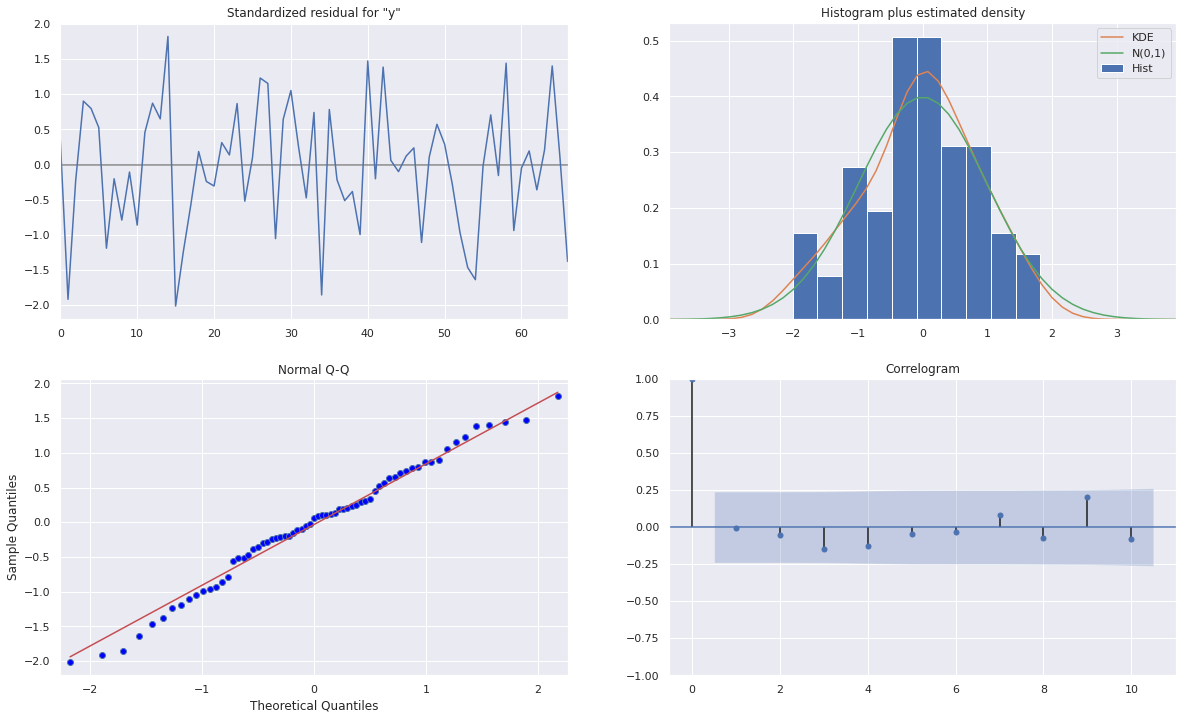

In [196]:
diagnostics = model.plot_diagnostics(figsize=(20, 12))